## Factor Analysis of US Equity data (~2500 stocks from Russell 3000)

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import datetime as dt

from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

import os.path

pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 5000

#### Load the data from files

In [2]:
# Load the cross-sectional dataframes for the past 5 years
data_dir="./data/cross/"
all_dates=pd.date_range(start='2016-03-01',end='2017-03-25')

# will contain only available dates
dates=[] 

# frames will be a dictionary of date->df for the date, loaded from files
frames = {}

for dt in all_dates:
    fname = data_dir + dt.strftime("%Y-%m-%d") + ".csv"
    if os.path.isfile(fname):
        print("loading {}".format(fname))
        df_dt = pd.read_csv(fname, index_col=0 )
        dates.append(dt)
        frames[dt] = df_dt
    else:
        print("skippping {}".format(fname))


loading ./data/cross/2016-03-01.csv
loading ./data/cross/2016-03-02.csv
loading ./data/cross/2016-03-03.csv
loading ./data/cross/2016-03-04.csv
skippping ./data/cross/2016-03-05.csv
skippping ./data/cross/2016-03-06.csv
loading ./data/cross/2016-03-07.csv
loading ./data/cross/2016-03-08.csv
loading ./data/cross/2016-03-09.csv
loading ./data/cross/2016-03-10.csv
loading ./data/cross/2016-03-11.csv
skippping ./data/cross/2016-03-12.csv
skippping ./data/cross/2016-03-13.csv
loading ./data/cross/2016-03-14.csv
loading ./data/cross/2016-03-15.csv
loading ./data/cross/2016-03-16.csv
loading ./data/cross/2016-03-17.csv
loading ./data/cross/2016-03-18.csv
skippping ./data/cross/2016-03-19.csv
skippping ./data/cross/2016-03-20.csv
loading ./data/cross/2016-03-21.csv
loading ./data/cross/2016-03-22.csv
loading ./data/cross/2016-03-23.csv
loading ./data/cross/2016-03-24.csv
skippping ./data/cross/2016-03-25.csv
skippping ./data/cross/2016-03-26.csv
skippping ./data/cross/2016-03-27.csv
loading ./

##### Exploratory data analysis, transforming the data

Data dictionary

| Variable | Description   |
|------|------|
| CHG_PCT_1D  | <b> Outcome </b> One day stock price percent change |
| CHG_PCT_365D | 365 Day Stock price percent change, will be used as <i>MOMENTUM</i> factor |
| CUR_MKT_CAP  |  Market Capitalization in millions USD, will be used as <i>SIZE</i> factor |
| EV_TO_T12M_SALES   | Enterprise value to sales, will be used as <i>VALUE</i> factor |
| GICS_1,2,3,4   | Four levels of GICS classification, will be used as <i>INDUSTRY</i> factors. These are categorical variabales   |


In [3]:
df = frames[dates[-1]]
df.head(3)

,CHG_PCT_1D,CHG_PCT_365D,CUR_MKT_CAP,EV_TO_T12M_SALES,GICS_1,GICS_2,GICS_3,GICS_4,PX_LAST,PX_VOLUME
A,-0.19,50.39,17107.73,3.66,35,3520,352030,35203010,53.08,2015289.00
AA,-2.25,46.90,5997.71,0.51,15,1510,151040,15104010,32.56,4110969.00
AAC,2.18,-70.18,189.05,2.18,35,3510,351020,35102020,7.98,119807.00


In [4]:
df.dtypes

CHG_PCT_1D          float64
CHG_PCT_365D        float64
CUR_MKT_CAP         float64
EV_TO_T12M_SALES    float64
GICS_1                int64
GICS_2                int64
GICS_3                int64
GICS_4                int64
PX_LAST             float64
PX_VOLUME           float64
dtype: object

In [5]:
df.describe()

,CHG_PCT_1D,CHG_PCT_365D,CUR_MKT_CAP,EV_TO_T12M_SALES,GICS_1,GICS_2,GICS_3,GICS_4,PX_LAST,PX_VOLUME
count,2554.00,2488.00,2555.00,2555.00,2555.00,2555.00,2555.00,2555.00,2554.00,2555.00
mean,0.00,16.80,9800.71,48.36,33.09,3327.27,332747.49,33274770.44,50.45,1294052.42
std,1.90,46.95,35353.47,821.79,13.58,1357.00,135696.23,13569624.72,113.38,3797484.70
min,-32.66,-98.31,20.25,0.01,10.00,1010.00,101010.00,10101010.00,0.41,46.00
25%,-0.67,-7.78,602.52,1.18,20.00,2030.00,203035.00,20303510.00,14.35,148868.50
50%,-0.03,15.64,1831.07,2.43,35.00,3510.00,351010.00,35101020.00,30.05,409330.00
75%,0.56,37.30,5916.05,4.79,45.00,4510.00,451015.00,45101510.00,59.57,1210734.50
max,21.13,581.59,737873.38,26706.89,60.00,6010.00,601020.00,60102040.00,3879.00,107481789.00


In [6]:
from sklearn.preprocessing import Imputer

# require to be not null: CHG_PCT_1D, CUR_MKT_CAP, GICS_1, GICS_2, GICS_3, GICS_4, PX_LAST
required = ['CHG_PCT_1D', 'CUR_MKT_CAP', 'GICS_1', 'GICS_2', 'GICS_3', 'GICS_4', 'PX_LAST', 'PX_VOLUME' ]

# impute the rest with the average
def clean_df(df):    
    dropped = df[required].dropna(how='any').index
    df_required = df.loc[dropped,:]
    
    imp = Imputer(missing_values=np.nan, strategy='mean', axis=0)
    imputed_df = pd.DataFrame(imp.fit_transform(df_required))
    imputed_df.columns = df_required.columns
    imputed_df.index = df_required.index
    
    return imputed_df


In [7]:
df_clean = clean_df(df)
df_clean.describe()

,CHG_PCT_1D,CHG_PCT_365D,CUR_MKT_CAP,EV_TO_T12M_SALES,GICS_1,GICS_2,GICS_3,GICS_4,PX_LAST,PX_VOLUME
count,2554.00,2554.00,2554.00,2554.00,2554.00,2554.00,2554.00,2554.00,2554.00,2554.00
mean,0.00,16.80,9804.49,48.37,33.08,3326.22,332642.45,33264266.42,50.45,1294559.08
std,1.90,46.34,35359.88,821.95,13.58,1356.22,135618.87,13561888.70,113.38,3798141.98
min,-32.66,-98.31,20.25,0.01,10.00,1010.00,101010.00,10101010.00,0.41,192.00
25%,-0.67,-7.25,604.15,1.18,20.00,2030.00,203032.50,20303260.00,14.35,149316.00
50%,-0.03,16.58,1832.23,2.43,35.00,3510.00,351010.00,35101020.00,30.05,410047.00
75%,0.56,36.67,5918.91,4.77,45.00,4510.00,451010.00,45101010.00,59.57,1211237.25
max,21.13,581.59,737873.38,26706.89,60.00,6010.00,601020.00,60102040.00,3879.00,107481789.00


In [8]:
# clean all dataframes
def apply_to_all_frames(func):
    for idx,dt in enumerate(dates):
        if idx % 10 == 0:
            print('applying to date {}'.format(dt))
        df_applied = func(frames[dt])
        frames[dt] = df_applied
        
apply_to_all_frames(clean_df)        

applying to date 2016-03-01 00:00:00
applying to date 2016-03-15 00:00:00
applying to date 2016-03-30 00:00:00
applying to date 2016-04-13 00:00:00
applying to date 2016-04-27 00:00:00
applying to date 2016-05-11 00:00:00
applying to date 2016-05-25 00:00:00
applying to date 2016-06-09 00:00:00
applying to date 2016-06-23 00:00:00
applying to date 2016-07-08 00:00:00
applying to date 2016-07-22 00:00:00
applying to date 2016-08-05 00:00:00
applying to date 2016-08-19 00:00:00
applying to date 2016-09-02 00:00:00
applying to date 2016-09-19 00:00:00
applying to date 2016-10-03 00:00:00
applying to date 2016-10-17 00:00:00
applying to date 2016-10-31 00:00:00
applying to date 2016-11-14 00:00:00
applying to date 2016-11-29 00:00:00
applying to date 2016-12-13 00:00:00
applying to date 2016-12-28 00:00:00
applying to date 2017-01-12 00:00:00
applying to date 2017-01-27 00:00:00
applying to date 2017-02-10 00:00:00
applying to date 2017-02-27 00:00:00
applying to date 2017-03-13 00:00:00


In [9]:
df = frames[dates[-1]]
df.head(3)

,CHG_PCT_1D,CHG_PCT_365D,CUR_MKT_CAP,EV_TO_T12M_SALES,GICS_1,GICS_2,GICS_3,GICS_4,PX_LAST,PX_VOLUME
A,-0.19,50.39,17107.73,3.66,35.00,3520.00,352030.00,35203010.00,53.08,2015289.00
AA,-2.25,46.90,5997.71,0.51,15.00,1510.00,151040.00,15104010.00,32.56,4110969.00
AAC,2.18,-70.18,189.05,2.18,35.00,3510.00,351020.00,35102020.00,7.98,119807.00


In [10]:
from scipy.stats import norm

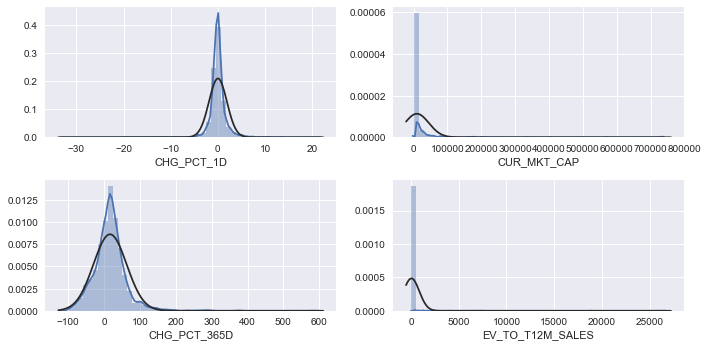

In [11]:
from scipy.stats import norm
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
for i, col in enumerate(['CHG_PCT_1D','CHG_PCT_365D','CUR_MKT_CAP','EV_TO_T12M_SALES']):
    sns.distplot(df[col], ax=axes[i%2, int(i/2)], fit=norm)
plt.tight_layout()   

In [12]:
# EV_TO_T12M_SALES should be 1/x : SALES_TO_EV
df['SALES_TO_EV'] = df['EV_TO_T12M_SALES'].map(lambda x: 1/x if x>0 else 0 )
df['CUR_MKT_CAP'] = df['CUR_MKT_CAP'].map(lambda x: 1 if x<=0 else x )

In [13]:
df.iloc[:2][['SALES_TO_EV','EV_TO_T12M_SALES']]

,SALES_TO_EV,EV_TO_T12M_SALES
A,0.27,3.66
AA,1.94,0.51


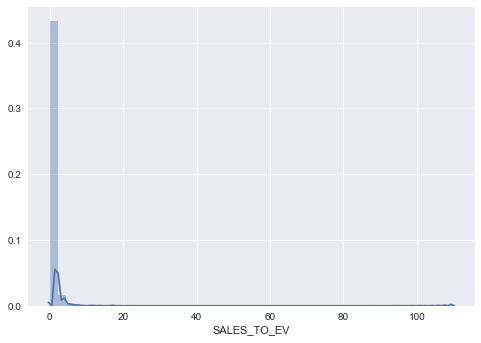

In [14]:
sns.distplot(df['SALES_TO_EV']);

In [15]:
df['SALES_TO_EV'].describe()

count   2554.00
mean       0.75
std        2.41
min        0.00
25%        0.21
50%        0.41
75%        0.85
max      109.89
Name: SALES_TO_EV, dtype: float64

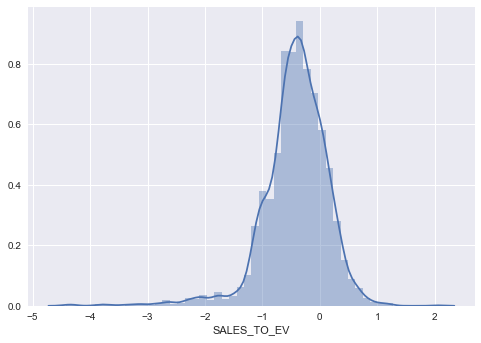

In [16]:
sns.distplot(np.log10(df['SALES_TO_EV']));

Conlusuion: need to take the logarithm of SALES_TO_EV

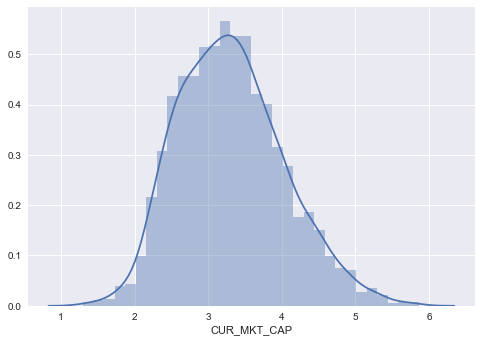

In [17]:
sns.distplot(np.log10(df['CUR_MKT_CAP']));

Conlusuion: need to take the logarithm of CUR_MKT_CAP

In [18]:
def transform_normalize_frame(df):
    df['CUR_MKT_CAP'] = df['CUR_MKT_CAP'].map(lambda x: 1 if x<=0 else x )
    df['LOG_CUR_MKT_CAP'] = np.log10(df['CUR_MKT_CAP'])
    
    df['SALES_TO_EV'] = df['EV_TO_T12M_SALES'].map(lambda x: 1/x if x>0 else 0 )    
    df['LOG_SALES_TO_EV'] = np.log10(df['SALES_TO_EV'])
    
    df['LOG_SALES_TO_EV_UNSCALED'] = df['LOG_SALES_TO_EV']
    
    # will not use these columns
    df = df.drop(['EV_TO_T12M_SALES', 'PX_LAST','PX_VOLUME'],axis=1)
    
    # standardize some columns
    cols_to_scale = [ 'CHG_PCT_365D', 'LOG_CUR_MKT_CAP', 'LOG_SALES_TO_EV' ]
    
    mean = df[cols_to_scale].mean()
    std = df[cols_to_scale].std()    
    df[cols_to_scale] = df[cols_to_scale].apply(lambda row: (row-mean)/std, axis=1)
    
    return df

In [19]:
df_norm = transform_normalize_frame(df)

In [20]:
df_norm.head(2) # GICS should not be transformed

,CHG_PCT_1D,CHG_PCT_365D,CUR_MKT_CAP,GICS_1,GICS_2,GICS_3,GICS_4,SALES_TO_EV,LOG_CUR_MKT_CAP,LOG_SALES_TO_EV,LOG_SALES_TO_EV_UNSCALED
A,-0.19,0.72,17107.73,35.00,3520.00,352030.00,35203010.00,0.27,1.29,-0.24,-0.56
AA,-2.25,0.65,5997.71,15.00,1510.00,151040.00,15104010.00,1.94,0.65,1.25,0.29


In [21]:
df_norm.describe()

,CHG_PCT_1D,CHG_PCT_365D,CUR_MKT_CAP,GICS_1,GICS_2,GICS_3,GICS_4,SALES_TO_EV,LOG_CUR_MKT_CAP,LOG_SALES_TO_EV,LOG_SALES_TO_EV_UNSCALED
count,2554.00,2554.00,2554.00,2554.00,2554.00,2554.00,2554.00,2554.00,2554.00,2554.00,2554.00
mean,0.00,0.00,9804.49,33.08,3326.22,332642.45,33264266.42,0.75,0.00,0.00,-0.43
std,1.90,1.00,35359.88,13.58,1356.22,135618.87,13561888.70,2.41,1.00,1.00,0.57
min,-32.66,-2.48,20.25,10.00,1010.00,101010.00,10101010.00,0.00,-2.79,-6.97,-4.43
25%,-0.67,-0.52,604.15,20.00,2030.00,203032.50,20303260.00,0.21,-0.74,-0.44,-0.68
50%,-0.03,-0.00,1832.23,35.00,3510.00,351010.00,35101020.00,0.41,-0.07,0.07,-0.39
75%,0.56,0.43,5918.91,45.00,4510.00,451010.00,45101010.00,0.85,0.64,0.62,-0.07
max,21.13,12.19,737873.38,60.00,6010.00,601020.00,60102040.00,109.89,3.56,4.31,2.04


In [22]:
apply_to_all_frames(transform_normalize_frame)

applying to date 2016-03-01 00:00:00
applying to date 2016-03-15 00:00:00
applying to date 2016-03-30 00:00:00
applying to date 2016-04-13 00:00:00
applying to date 2016-04-27 00:00:00
applying to date 2016-05-11 00:00:00
applying to date 2016-05-25 00:00:00
applying to date 2016-06-09 00:00:00
applying to date 2016-06-23 00:00:00
applying to date 2016-07-08 00:00:00
applying to date 2016-07-22 00:00:00
applying to date 2016-08-05 00:00:00
applying to date 2016-08-19 00:00:00
applying to date 2016-09-02 00:00:00
applying to date 2016-09-19 00:00:00
applying to date 2016-10-03 00:00:00
applying to date 2016-10-17 00:00:00
applying to date 2016-10-31 00:00:00
applying to date 2016-11-14 00:00:00
applying to date 2016-11-29 00:00:00
applying to date 2016-12-13 00:00:00
applying to date 2016-12-28 00:00:00
applying to date 2017-01-12 00:00:00
applying to date 2017-01-27 00:00:00
applying to date 2017-02-10 00:00:00
applying to date 2017-02-27 00:00:00
applying to date 2017-03-13 00:00:00


## Three-factor model (no industry factors)

Regresssing 1 day return on scaled 1 year return, scaled log market cap, and scaled log sales to enterprise value

In [23]:
mod = smf.ols(formula='CHG_PCT_1D ~ CHG_PCT_365D + LOG_CUR_MKT_CAP + LOG_SALES_TO_EV', data=df_norm)

In [24]:
res = mod.fit()
print res.summary()

                            OLS Regression Results                            
Dep. Variable:             CHG_PCT_1D   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     17.35
Date:                Tue, 28 Mar 2017   Prob (F-statistic):           3.78e-11
Time:                        22:44:46   Log-Likelihood:                -5235.5
No. Observations:                2554   AIC:                         1.048e+04
Df Residuals:                    2550   BIC:                         1.050e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0032      0.037     

The skew and kurtosis of the residuals indicate that the residuals are <font color="red">strongly non-normal</font>. Let's look at the regression and residual plots

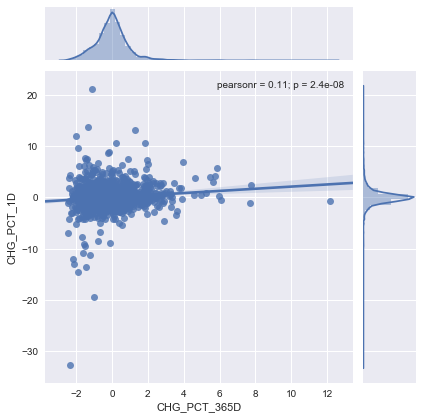

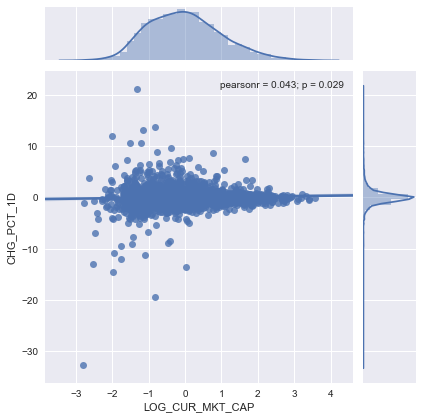

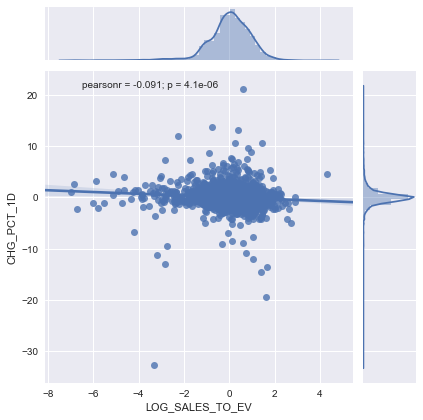

In [25]:
#fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
for i, col in enumerate(['CHG_PCT_365D', 'LOG_CUR_MKT_CAP', 'LOG_SALES_TO_EV']):
    #sns.residplot(y='Sales', x=col, data=data, ax=axes[i])
    sns.jointplot(col,'CHG_PCT_1D', data=df_norm, kind="reg");

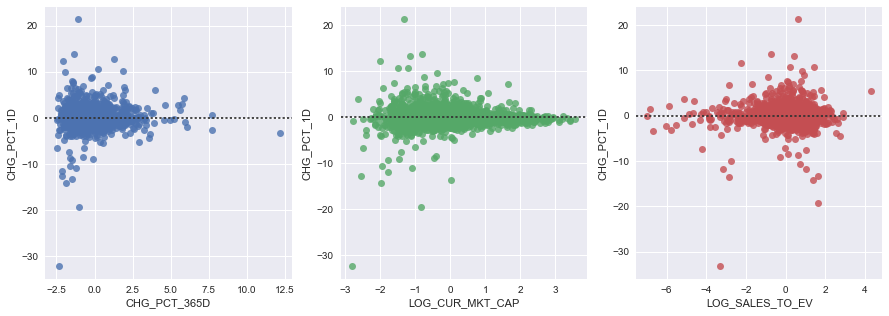

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i, col in enumerate(['CHG_PCT_365D', 'LOG_CUR_MKT_CAP', 'LOG_SALES_TO_EV']):
    sns.residplot(y='CHG_PCT_1D', x=col, data=df_norm, ax=axes[i])

There are at least two problems - one is outliers that should be dealt with. Second is apparent relationship between the size of residuals and the market cap - for larger companies the variance of return is much smaller than for the smaller companies. We need to address this. There is also a dependence in the residual on LOG_SALES_TO_EV.

### Exponential relationship between the return and the market cap of the company

Let's try to find the exponential relationship between the magnitude of 1D return and the market cap of the company by running the regression ln(return) ~ ln(market cap)

In [27]:
def add_log(df):
    df['LOG_CHG_PCT_1D_SQUARED'] = df['CHG_PCT_1D'].map(lambda x:  np.nan if x==0 else np.log(pow(x,2)) )     
    df['LOG_CUR_MKT_CAP_UNSCALED'] = np.log( df['CUR_MKT_CAP'] )
    return df

In [28]:
df_norm_log = add_log(df_norm)

In [29]:
df_norm_log.head(2)

,CHG_PCT_1D,CHG_PCT_365D,CUR_MKT_CAP,GICS_1,GICS_2,GICS_3,GICS_4,SALES_TO_EV,LOG_CUR_MKT_CAP,LOG_SALES_TO_EV,LOG_SALES_TO_EV_UNSCALED,LOG_CHG_PCT_1D_SQUARED,LOG_CUR_MKT_CAP_UNSCALED
A,-0.19,0.72,17107.73,35.00,3520.00,352030.00,35203010.00,0.27,1.29,-0.24,-0.56,-3.34,9.75
AA,-2.25,0.65,5997.71,15.00,1510.00,151040.00,15104010.00,1.94,0.65,1.25,0.29,1.62,8.70


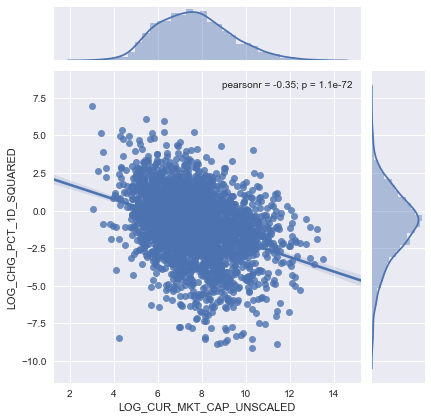

In [30]:
sns.jointplot('LOG_CUR_MKT_CAP_UNSCALED', 'LOG_CHG_PCT_1D_SQUARED', data=df_norm_log, kind="reg");

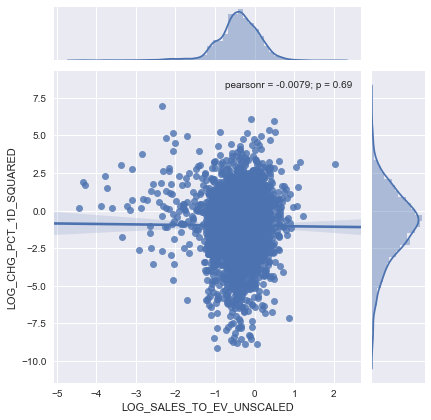

In [31]:
sns.jointplot('LOG_SALES_TO_EV_UNSCALED', 'LOG_CHG_PCT_1D_SQUARED', data=df_norm_log, kind="reg");

In [32]:
mod = smf.ols(formula='LOG_CHG_PCT_1D_SQUARED ~ LOG_CUR_MKT_CAP_UNSCALED', data=df_norm)
res = mod.fit()
print res.summary()

                              OLS Regression Results                              
Dep. Variable:     LOG_CHG_PCT_1D_SQUARED   R-squared:                       0.124
Model:                                OLS   Adj. R-squared:                  0.124
Method:                     Least Squares   F-statistic:                     347.8
Date:                    Tue, 28 Mar 2017   Prob (F-statistic):           1.08e-72
Time:                            22:44:55   Log-Likelihood:                -5309.7
No. Observations:                    2451   AIC:                         1.062e+04
Df Residuals:                        2449   BIC:                         1.063e+04
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

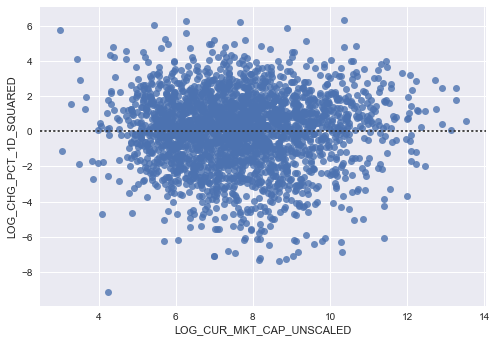

In [33]:
sns.residplot(y='LOG_CHG_PCT_1D_SQUARED', x='LOG_CUR_MKT_CAP_UNSCALED', data=df_norm_log);

Run the regression over 1 year to get an estimate of the coefficient on different dates

In [34]:
res.params['LOG_CUR_MKT_CAP_UNSCALED']

-0.480952147799943

In [35]:
apply_to_all_frames(add_log)

applying to date 2016-03-01 00:00:00
applying to date 2016-03-15 00:00:00
applying to date 2016-03-30 00:00:00
applying to date 2016-04-13 00:00:00
applying to date 2016-04-27 00:00:00
applying to date 2016-05-11 00:00:00
applying to date 2016-05-25 00:00:00
applying to date 2016-06-09 00:00:00
applying to date 2016-06-23 00:00:00
applying to date 2016-07-08 00:00:00
applying to date 2016-07-22 00:00:00
applying to date 2016-08-05 00:00:00
applying to date 2016-08-19 00:00:00
applying to date 2016-09-02 00:00:00
applying to date 2016-09-19 00:00:00
applying to date 2016-10-03 00:00:00
applying to date 2016-10-17 00:00:00
applying to date 2016-10-31 00:00:00
applying to date 2016-11-14 00:00:00
applying to date 2016-11-29 00:00:00
applying to date 2016-12-13 00:00:00
applying to date 2016-12-28 00:00:00
applying to date 2017-01-12 00:00:00
applying to date 2017-01-27 00:00:00
applying to date 2017-02-10 00:00:00
applying to date 2017-02-27 00:00:00
applying to date 2017-03-13 00:00:00


In [36]:
coeffs = []
for idx,dt in enumerate(dates):
    if idx % 10 == 0:
        print('running regression on date {}'.format(dt))
    mod = smf.ols(formula='LOG_CHG_PCT_1D_SQUARED ~ LOG_CUR_MKT_CAP_UNSCALED', data=frames[dt])
    res = mod.fit()    
    coeffs.append(res.params['LOG_CUR_MKT_CAP_UNSCALED'])

running regression on date 2016-03-01 00:00:00
running regression on date 2016-03-15 00:00:00
running regression on date 2016-03-30 00:00:00
running regression on date 2016-04-13 00:00:00
running regression on date 2016-04-27 00:00:00
running regression on date 2016-05-11 00:00:00
running regression on date 2016-05-25 00:00:00
running regression on date 2016-06-09 00:00:00
running regression on date 2016-06-23 00:00:00
running regression on date 2016-07-08 00:00:00
running regression on date 2016-07-22 00:00:00
running regression on date 2016-08-05 00:00:00
running regression on date 2016-08-19 00:00:00
running regression on date 2016-09-02 00:00:00
running regression on date 2016-09-19 00:00:00
running regression on date 2016-10-03 00:00:00
running regression on date 2016-10-17 00:00:00
running regression on date 2016-10-31 00:00:00
running regression on date 2016-11-14 00:00:00
running regression on date 2016-11-29 00:00:00
running regression on date 2016-12-13 00:00:00
running regre

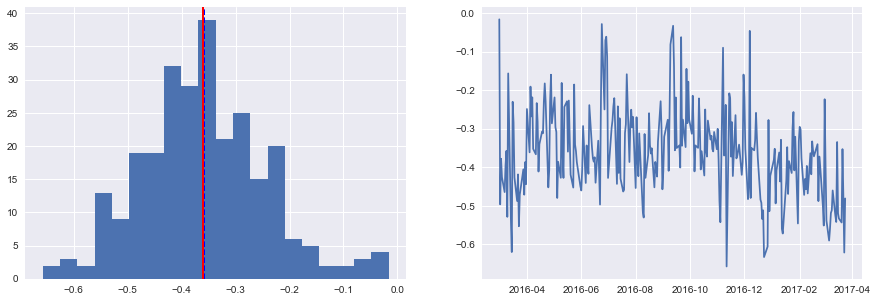

In [37]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.hist(coeffs, bins=20);
plt.axvline(np.mean(coeffs), color='b', linestyle='dashed', linewidth=2);
plt.axvline(np.median(coeffs), color='r', linestyle='solid', linewidth=2);

plt.subplot(122)
plt.plot(dates,coeffs);

In [38]:
print('mean={}'.format(np.mean(coeffs)))
print('std={}'.format(np.std(coeffs)))

mean=-0.358899721118
std=0.117242650205


##  Weighted least squares (WLS)

In [39]:
Y = df_norm['CHG_PCT_1D'].values

In [40]:
X = df_norm[['CHG_PCT_365D','LOG_CUR_MKT_CAP','LOG_SALES_TO_EV']].values

In [41]:
X = sm.add_constant(X)

In [42]:
weights = pow( df_norm['CUR_MKT_CAP'].values, 0.48)

In [43]:
wls_model = sm.WLS(Y,X, weights=weights )
results = wls_model.fit()

In [44]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.025
Model:                            WLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     21.95
Date:                Tue, 28 Mar 2017   Prob (F-statistic):           4.96e-14
Time:                        22:45:02   Log-Likelihood:                -4684.3
No. Observations:                2554   AIC:                             9377.
Df Residuals:                    2550   BIC:                             9400.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0399      0.033      1.227      0.220      -0.024       0.104
x1             0.0875      0.029      3.020      0.003       0.031       0.144
x2            -0.0597      0.023     -2.605      0.009      -0.105      -0.015
x3            -0.2200      0.031     -7.101      0.000      -0.281      -0.159
==============================================================================
Omnibus:                      764.916   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28818.487
Skew:                           0.717   Prob(JB):                         0.00
Kurtosis:                      19.394   Cond. No.                         2.33
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Visually check for conditional heteroscedasticity: residuals against regressors

In [45]:
df_resid = pd.DataFrame({'resid_squared': pow(results.resid, 2) , 'scaled_log_mcap': df_norm['LOG_CUR_MKT_CAP'].values})

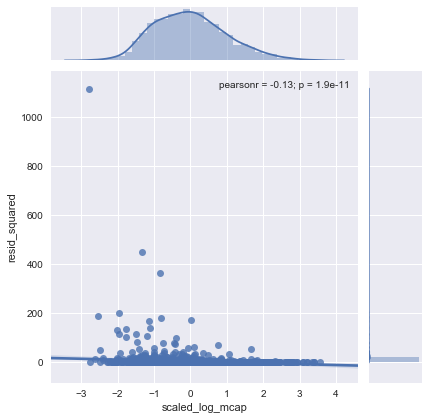

In [46]:
sns.jointplot('scaled_log_mcap', 'resid_squared', data=df_resid, kind="reg");

## Adding GICS categories to the WLS model

In [80]:
categories = ['GICS_1','GICS_2','GICS_3','GICS_4']
for gics in categories:
    print("{} categories={}".format(gics,  len(df_norm[gics].unique()) ) )

GICS_1 categories=11
GICS_2 categories=24
GICS_3 categories=68
GICS_4 categories=154


In [47]:
wls_model = smf.wls(formula='CHG_PCT_1D ~ CHG_PCT_365D + LOG_CUR_MKT_CAP + LOG_SALES_TO_EV + C(GICS_1)', data=df_norm, weights=weights )


In [48]:
results = wls_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:             CHG_PCT_1D   R-squared:                       0.107
Model:                            WLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     23.43
Date:                Tue, 28 Mar 2017   Prob (F-statistic):           6.60e-54
Time:                        22:45:04   Log-Likelihood:                -4572.2
No. Observations:                2554   AIC:                             9172.
Df Residuals:                    2540   BIC:                             9254.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.1069      0.103     -1.036      0.300      -0.309       0.095
C(GICS_1)[T.15.0]    -0.8802      0.149     -5.903      0.000      -1.173      -0.588
C(GICS_1)[T.20.0]    -0.1596      0.122     -1.304      0.192      -0.400       0.080
C(GICS_1)[T.25.0]     0.3192      0.119      2.679      0.007       0.086       0.553
C(GICS_1)[T.30.0]     0.1069      0.139      0.769      0.442      -0.166       0.379
C(GICS_1)[T.35.0]     0.7233      0.120      6.003      0.000       0.487       0.960
C(GICS_1)[T.40.0]    -0.0930      0.129     -0.724      0.469      -0.345       0.159
C(GICS_1)[T.45.0]     0.3297      0.118      2.802      0.005       0.099       0.561
C(GICS_1)[T.50.0]     0.6210      0.228      2.723      0.007       0.174       1.068
C(GICS_1)[T.55.0]     0.5197      0.159      3.276      0.001       0.209       0.831
C(GICS_1)[T.60.0]    -0.0340      0.139     -0.245      0.806      -0.306       0.238
CHG_PCT_365D          0.1175      0.029      4.089      0.000       0.061       0.174
LOG_CUR_MKT_CAP      -0.0785      0.022     -3.501      0.000      -0.122      -0.035
LOG_SALES_TO_EV      -0.1568      0.033     -4.706      0.000      -0.222      -0.091
==============================================================================
Omnibus:                      753.798   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37565.982
Skew:                           0.601   Prob(JB):                         0.00
Kurtosis:                      21.750   Cond. No.                         23.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
wls_model = smf.wls(formula='CHG_PCT_1D ~ CHG_PCT_365D + LOG_CUR_MKT_CAP + LOG_SALES_TO_EV + C(GICS_2)', data=df_norm, weights=weights )

In [50]:
results = wls_model.fit()
results.rsquared

0.12956129609168965

In [145]:
wls_model = smf.wls(formula='CHG_PCT_1D ~ CHG_PCT_365D + LOG_CUR_MKT_CAP + LOG_SALES_TO_EV + C(GICS_3)', data=df_norm, weights=weights )

In [146]:
results = wls_model.fit()
results.rsquared

0.1652068515903613

In [147]:
y_hat = results.predict(df_norm)
mse = metrics.mean_squared_error(y_hat, df_norm['CHG_PCT_1D'])
print('In sample mse={}'.format(mse))

In sample mse=3.32838383822


In [149]:
wls_model = smf.wls(formula='CHG_PCT_1D ~ CHG_PCT_365D + LOG_CUR_MKT_CAP + LOG_SALES_TO_EV + C(GICS_4)', data=df_norm, weights=weights )

In [150]:
results = wls_model.fit()
results.rsquared

0.22590326553045093

In [151]:
y_hat = results.predict(df_norm)
mse = metrics.mean_squared_error(y_hat, df_norm['CHG_PCT_1D'])
print('In sample mse={}'.format(mse))

In sample mse=3.18589178525


##  Cross-validation to get the right GICS depth

In [63]:
from sklearn import cross_validation
from sklearn import metrics

C:\Program Files\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Find the minimum number of securities withing a GICS category

In [87]:
categories = ['GICS_1','GICS_2','GICS_3','GICS_4']
for gics in categories:
    print("{} min number of securities in a category={}".format(gics,  df_norm.groupby(gics).count()['CHG_PCT_1D'].min() ) )

GICS_1 min number of securities in a category=30
GICS_2 min number of securities in a category=15
GICS_3 min number of securities in a category=1
GICS_4 min number of securities in a category=1


In [127]:
df_norm['GICS_1'].value_counts()

25.00    423
45.00    420
35.00    398
20.00    385
40.00    235
60.00    185
10.00    149
15.00    132
30.00    117
55.00     80
50.00     30
Name: GICS_1, dtype: int64

In [126]:
df_norm[df_norm['GICS_3']==203050.00].sample(frac=0.2)

,CHG_PCT_1D,CHG_PCT_365D,CUR_MKT_CAP,GICS_1,GICS_2,GICS_3,GICS_4,SALES_TO_EV,LOG_CUR_MKT_CAP,LOG_SALES_TO_EV,LOG_SALES_TO_EV_UNSCALED,LOG_CHG_PCT_1D_SQUARED,LOG_CUR_MKT_CAP_UNSCALED


In [136]:
kf = cross_validation.KFold(len(df_norm), n_folds=5 )
#def get_train_test(gics, n_folds=5):
#    fract=1.0/n_folds
#    test = []
#    for gics, num in df_norm[gics].value_counts().iterrows():
#        if num>=n_folds:
            

In [155]:
for gics in ['GICS_1','GICS_2']:
    formula = 'CHG_PCT_1D ~ CHG_PCT_365D + LOG_CUR_MKT_CAP + LOG_SALES_TO_EV ' + '+' + ' C('+gics+')'
    mses = []
    for train_index, test_index in kf:
        wls_mod = smf.wls(formula=formula, data=df_norm.iloc[train_index], weights=weights[train_index] )
        res = wls_mod.fit()
        y_hat = res.predict(df_norm.iloc[test_index])
        mse = metrics.mean_squared_error(y_hat, df_norm.iloc[test_index]['CHG_PCT_1D'])
        #r2 = metrics.r2_score(y_hat, df_norm.iloc[test_index]['CHG_PCT_1D'])
        mses.append(mse)
    
    print("gics={}, mse={}, std={}".format(gics, np.mean(mses), np.std(mses)))    

gics=GICS_1, mse=3.44505743134, std=1.15150011105
gics=GICS_2, mse=3.4222818697, std=1.14116928228


## Random Forest Regressor

In [131]:
cols = [ 'CHG_PCT_365D', 'LOG_CUR_MKT_CAP', 'LOG_SALES_TO_EV' ,'GICS_1' ] 
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor( n_estimators=100 )

In [134]:
for gics in ['GICS_1','GICS_2']:
    formula = 'CHG_PCT_1D ~ CHG_PCT_365D + LOG_CUR_MKT_CAP + LOG_SALES_TO_EV ' + '+' + ' C('+gics+')'
    mses = []
    for train_index, test_index in kf:
        rf.fit(df_norm.iloc[train_index][cols], df_norm.iloc[train_index]['CHG_PCT_1D'])
        
        y_hat = rf.predict(df_norm.iloc[test_index])
        mse = metrics.mean_squared_error(y_hat, df_norm.iloc[test_index]['CHG_PCT_1D'])
        mses.append(mse)
    
    print("gics={}, mse={}, std={}".format(gics, np.mean(mses), np.std(mses))) 

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [133]:
rf.fit(df_norm[cols], df_norm['CHG_PCT_1D'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [135]:
y_hat = rf.predict(df_norm.iloc[test_index])

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').